In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import cv2 as cv
import os
import numpy as np
import pytorch_lightning as pl
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

In [2]:
comparable_data = pd.read_csv("comparable_data.csv")
comparable_data.head(3)

,title,price,cat_1,cat_2,cat_3,caracteristics,img_ref,target,dealer
0,Беговая дорожка UNIXFIT MX-990X,120890,Беговые дорожки,UNIXFIT,UNIXFIT MX-990X,Тип электрическая Уровень базовый Габариты (...,images/begovye_dorozhki/1_begdorozhki_1349.jpeg,begovye_dorozhki,begdorozhki
1,"Беговая дорожка Proxima Ivetta HRC, Арт. PROT-219",139990,Беговые дорожки,Proxima,"Proxima Ivetta HRC, Арт. PROT-219",Тип электрическая Уровень базовый Габариты (...,images/begovye_dorozhki/2_begdorozhki_1463.jpeg,begovye_dorozhki,begdorozhki
2,"Беговая дорожка UNIXFIT MX-990 AC (10,1"" TFT)",159890,Беговые дорожки,UNIXFIT,"UNIXFIT MX-990 AC (10,1"" TFT)",Тип электрическая Уровень полупрофессиональны...,images/begovye_dorozhki/3_begdorozhki_1638.jpeg,begovye_dorozhki,begdorozhki


In [3]:
train, test = train_test_split(comparable_data, test_size=0.1, random_state=2012)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12346 entries, 10452 to 5016
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           12346 non-null  object
 1   price           12346 non-null  int64 
 2   cat_1           10108 non-null  object
 3   cat_2           12346 non-null  object
 4   cat_3           12342 non-null  object
 5   caracteristics  11122 non-null  object
 6   img_ref         12346 non-null  object
 7   target          12346 non-null  object
 8   dealer          12346 non-null  object
dtypes: int64(1), object(8)
memory usage: 964.5+ KB


In [5]:
def create_folders(df, purpose):
    for _, row in df.iterrows():
        target_directory = f'class_dataset/{purpose}/{row["target"]}'
        if not os.path.exists(target_directory):
            os.makedirs(target_directory)
        filename = row['img_ref']
        shutil.copy(filename, target_directory)

In [6]:
create_folders(train, 'train')
create_folders(test, "val")

In [7]:
def view_random_images(cols, rows, path_to_images):
    fig = plt.figure(figsize = (2 * cols-1, 2.5*rows -1))
    images = os.listdir(path_to_images)
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(images))
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            img = cv.imread(os.path.join(path_to_images, images[random_index]))
            ax.imshow(img[..., ::-1])
            plt.title(img.shape)
    plt.show()

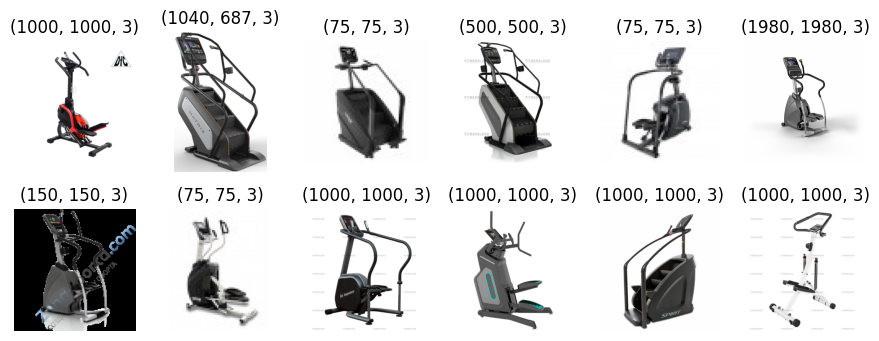

In [8]:
view_random_images(6, 2, "class_dataset/train/steppery")

In [9]:
def create_datasets(path_to_data, batch_size, transforms):
    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(path_to_data, x), transforms[x]
        )
        for x in ["train", "val"]
    }

    # create dataloaders
    train_dataloader = torch.utils.data.DataLoader(
        image_datasets["train"],
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        drop_last=True,
        persistent_workers=True,
    )
    val_dataloader = torch.utils.data.DataLoader(
        image_datasets["val"],
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        drop_last=True,
        persistent_workers=True,
    )

    dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
    print(dataset_sizes)
    return train_dataloader, val_dataloader

In [10]:
def get_model(num_classes):
    weights = models.ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)
    # Update the fully connected layer based on the number of classes in the dataset
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    return model

In [11]:
num_classes = len(np.unique(comparable_data['target'].tolist()))
num_classes

8

Создам класс для модели, в нем укажу паарамтеры обучения и валидации

In [12]:
class LitModel(pl.LightningModule):
    def __init__(self, num_epochs, len_dataset, learning_rate):
        super().__init__()
        self.model = get_model(num_classes=num_classes)
        self.loss_fn = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.len_dataset = len_dataset

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("train_loss", loss, on_epoch = True, on_step=False, logger = True)
        self.log("train_acc", acc, on_epoch=True, on_step=False, logger = True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            self.learning_rate,
            epochs=self.num_epochs,
            steps_per_epoch=self.len_dataset,
        )
        return [optimizer], [scheduler]

In [13]:
data_transforms_baseline = {
    "train": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}


train_dl, val_dl = create_datasets("class_dataset", 16, data_transforms_baseline)

{'train': 12346, 'val': 1372}


In [14]:
num_epochs = 15
len_dataset = len(train_dl)
learning_rate = 0.001

trainer = pl.Trainer(max_epochs=num_epochs, gradient_clip_val=0.1)
model = LitModel(num_epochs, len_dataset, learning_rate)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Kate\Desktop\cv_project\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_f

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [15]:
trainer.save_checkpoint("resnet_class_v1.ckpt")

In [16]:
trainer.save_checkpoint("resnet_class_v1.ckpt", weights_only=True)